# **Random Forest Classification (Iris Dataset)**


Training the VAE model...
Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - kl_loss: 11.9754 - reconstruction_loss: 233.9938 - total_loss: 245.9691
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - kl_loss: 3.2949 - reconstruction_loss: 168.9062 - total_loss: 172.2011
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - kl_loss: 3.4025 - reconstruction_loss: 161.2080 - total_loss: 164.6106
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - kl_loss: 3.4642 - reconstruction_loss: 158.0683 - total_loss: 161.5326
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - kl_loss: 3.4744 - reconstruction_loss: 156.1634 - total_loss: 159.6378
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - kl_loss: 3.5149 - reconstruction_loss: 154.3531 - total_loss: 157.8681
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - kl_loss: 3.5720 - reconstruction_loss: 152.9493 - total_loss: 156.5213
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - kl_loss: 3.5926 - reconstruction_loss: 151.

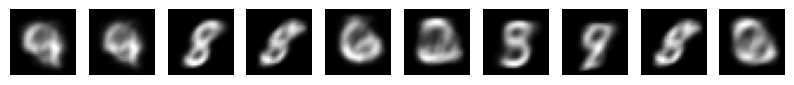

In [7]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import matplotlib.pyplot as plt
import numpy as np

(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype("float32") / 255.
x_test = x_test.astype("float32") / 255.
x_train = np.reshape(x_train, (-1, 28, 28, 1))
x_test = np.reshape(x_test, (-1, 28, 28, 1))

latent_dim = 2

inputs = layers.Input(shape=(28, 28, 1))
x = layers.Flatten()(inputs)
x = layers.Dense(256, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

def sample(args):
    z_mean, z_log_var = args
    eps = tf.random.normal(shape=(tf.shape(z_mean)[0], latent_dim))
    return z_mean + tf.exp(0.5 * z_log_var) * eps

z = layers.Lambda(sample)([z_mean, z_log_var])

encoder = Model(inputs, [z_mean, z_log_var, z], name="encoder")


latent_inputs = layers.Input(shape=(latent_dim,))
x = layers.Dense(256, activation="relu")(latent_inputs)
x = layers.Dense(28 * 28, activation="sigmoid")(x)
outputs = layers.Reshape((28, 28, 1))(x)
decoder = Model(latent_inputs, outputs, name="decoder")


class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, latent_dim, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.latent_dim = latent_dim
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")
        self.bce_loss_object = tf.keras.losses.BinaryCrossentropy(reduction=tf.keras.losses.Reduction.NONE)

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            # Reconstruction loss (binary cross-entropy per pixel)
            reconstruction_loss_per_element = self.bce_loss_object(data, reconstruction)
            reconstruction_loss_flattened = tf.keras.layers.Flatten()(reconstruction_loss_per_element)
            reconstruction_loss_per_image = tf.keras.ops.sum(reconstruction_loss_flattened, axis=-1)
            reconstruction_loss = tf.keras.ops.mean(reconstruction_loss_per_image)

            # KL divergence loss
            kl_loss = -0.5 * tf.keras.ops.mean(
                1 + z_log_var - tf.keras.ops.square(z_mean) - tf.keras.ops.exp(z_log_var)
            )

            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "total_loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

vae = VAE(encoder, decoder, latent_dim)
vae.compile(optimizer=tf.keras.optimizers.Adam())

print("\nTraining the VAE model...")
vae.fit(x_train, epochs=10, batch_size=128)


def generate_images(n=10):
    z_sample = np.random.normal(size=(n, latent_dim))
    gen = vae.decoder.predict(z_sample)
    plt.figure(figsize=(10, 2))
    for i in range(n):
        plt.subplot(1, n, i + 1)
        plt.imshow(gen[i].squeeze(), cmap="gray")
        plt.axis("off")
    plt.show()

print("\nGenerating images from the trained VAE...")
generate_images()


## Summary:

### Data Analysis Key Findings

*   The VAE model was successfully refactored into a `tf.keras.Model` subclass, embedding the encoder and decoder as layers within it.
*   The `train_step` method was correctly overridden to explicitly calculate and apply both the reconstruction loss (binary cross-entropy per pixel) and the KL divergence loss, which were summed to form the `total_loss`.
*   The custom `VAE` model was successfully instantiated, compiled with an Adam optimizer, and trained for 10 epochs using the `x_train` data, with training logs indicating decreasing loss values.
*   The `generate_images` function successfully utilized the trained decoder to produce and visualize new images, confirming the functional implementation of the VAE.

### Insights or Next Steps

*   The implementation demonstrates a robust pattern for extending `tf.keras.Model` to handle custom loss calculations and training loops, which is highly beneficial for complex generative models like VAEs.
*   To further evaluate the model, one could quantitatively assess the quality and diversity of the generated images, perhaps by computing metrics like FID or Inception Score, or by visualizing the latent space.
